# Traffic Matrix Estimation with Kalman Filtering
## Inference Module

In [2]:
import numpy as np
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import inv
from scipy.sparse import identity
import gc

I = np.eye
sparse = csc_matrix
randn = np.random.normal
choice = np.random.choice

def Is(n):
    return identity(n,format='csc')


class InferenceModule:
    """
    Kalman Filter with a decision function
    
    Parameters
    -------
    A : matrix
        The routing matrix
        
    links : dict
        The dictionary that maps switches to their links
        Ex. { 1 : [2,6], 2 : [1,3,5] } 
        which means Switch 1 is connected to the links 2 and 6,
        and Switch 2 is connected to the links 1, 3 and 5.
        
    v : float, optional
        The standard deviation of transition density
        
    e : float, optional
        The standard deviation of measurement density

    Methods
    -------
    filter(m,M)
        Predicts the estimates and updates them with the observation.
    decide(n)
        Decides which switches are going to be queried.
    _generate()
        Generates a new state conditioned on the current state, for testing purposes only.
    _measure(M)
        Partially measures the packet count vector, for testing purposes only.

    """
    def __init__(self,A,links,v=1,e=0.001):
        
        # L is the number of links
        # H2 is the number of flows
        L, H2 = A.shape
        LH2 = L + H2
        
        # The state estimate
        x = np.zeros(LH2)
        
        # The transition matrix
        F = sparse(np.bmat([
            [I(H2),   np.zeros((H2,L))],
            [A,       I(L)            ]
        ]))
        
        # The transition covariance
        Q = sparse(v**2*np.bmat([
            [I(H2),            np.zeros((H2,L))],
            [np.zeros((L,H2)), np.zeros((L,L)) ]
        ]))
        
        # The estiamte covariance
        P = sparse(np.zeros((LH2,LH2)))
        
        # The measurement matrix that measures all packet counts 
        # Used in the decision funciton
        M = sparse(np.bmat([np.zeros((L,H2)),  I(L)]))
        
        self.L, self.H2, self.LH2 = (L,H2,LH2)
        self.x, self.F, self.Q, self.P = (x,F,Q,P)

        self.links, self.M = (links,M)
        self.M = M
        
        self.v, self.e = (v,e)
        
        # The actual state vector used for testing purposes
        self._ax = np.zeros(LH2)

        gc.collect()
    
    def filter(self,m,M):
        """
        Predicts the estimates and updates them with the observation.
        
        Parameters
        -------
        m : array
            The measured packet counts
        M : matrix
            The measurement matrix
        """
        x, Q, P, F, e = (self.x, self.Q, self.P, self.F, self.e)
        
        # Predict
        x = F.dot(x)
        P = ((F.dot(P)).dot(F.T)) + Q
        
        # Update
        y = m - (M.dot(x))
        S = e**2*Is(M.shape[0]) + ((M.dot(P)).dot(M.T))
        K = (P.dot(M.T)).dot(inv(S))  # Kalman gain
        x = x + (K.dot(y))
        P = (Is(P.shape[0]) - (K.dot(M))).dot(P)
        P[P<0] = 0  # TODO: Must be tested!
        
        self.P, self.x = (P, x)

    def decide(self,n=1):
        """
        Returns the switches which are going to be queried
        and the corresponding measurement matrix
        
        Parameters
        -------
        n : int
            The number of switches to be queried
        """
        P, H2 = (self.P, self.H2)
        
        diag_cov = self.P.diagonal()[H2:]
        
        scores = []  # The switch scores
        keys = self.links.keys()
        for s in keys:
            # Sum all the variances of the packet counts of the links 
            # which are connected to the switch
            scores.append(np.sum(diag_cov[self.links[s]]))
            
        scores = scores/np.sum(scores)
        switches = choice(list(keys),n,p=scores)
        
        links = set()
        for s in switches:
            links.update(self.links[s])
        links = sorted(list(links))
        
        return switches, self.M[links,:]
    
    def _generate(self):
        """
        Generates a new state conditioned on the current state
        """
        ax, F, H2, v = (self._ax, self.F, self.H2, self.v)
        ax = F.dot(ax)
        ax[:H2] += randn(0,v,H2)
        self._ax = ax.clip(min=0)
    
    def _measure(self,M):
        """
        Partially measures the packet count vector
        
        Parameters
        -------
        M : matrix
            The measurement matrix
        """
        ax, e = (self._ax, self.e)
        y = M.dot(ax) + randn(0,e,M.shape[0])
        return y.clip(min=0)
        

## Test

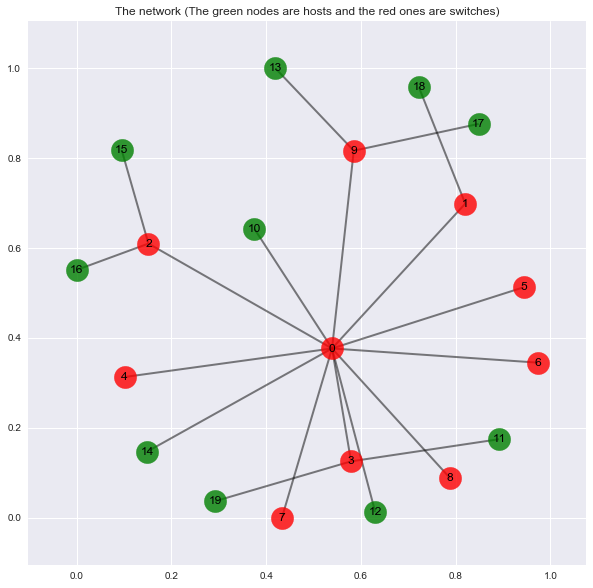

C:\Users\akb\Anaconda3\lib\site-packages\ipykernel\__main__.py:139: RuntimeWarning: invalid value encountered in true_divide
C:\Users\akb\Anaconda3\lib\site-packages\ipykernel\__main__.py:140: RuntimeWarning: invalid value encountered in less


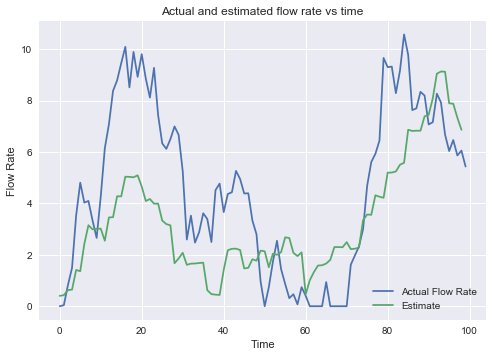

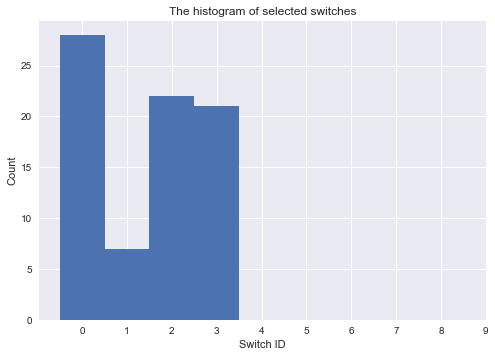

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Fix the seed for debugging
seed=1234577
np.random.seed(seed)

nH = 10  # The number of hosts
nS = 10  # The number of switches
N = nH + nS  # The number of nodes

# Create a graph of switches
G = nx.star_graph(nS-1)
# G = nx.complete_graph(nS)

switches = list(range(nS))  # The list of switch ids
hosts = list(range(nS, N))  # The list of host ids

# Append hosts
host_switches = np.random.choice(nS, nH)
for i in range(nH):
    host = nS + i
    G.add_node(host)
    G.add_edge(host_switches[i], host)
    
# Plot the graph    
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=switches,
                       node_color='r', node_size=500, alpha=0.8,with_labels=True)
nx.draw_networkx_nodes(G, pos, nodelist=hosts,
                       node_color='g', node_size=500, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=2.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, width=2.0, alpha=0.9)
plt.title('The network (The green nodes are hosts and the red ones are switches)')
plt.show()  


# The links are directed edges represented by (source,destination) pairs 
edges = G.edges()
nL = len(edges)
L = 2*nL  # The number of directed links

links = {}  # Maps switch ids to their link id list
for s in switches:
    links[s] = []

# Populate the dictionaries

lpair2id = {}  # A mapping from edge pairs (src,dst) to link ids
for i,edge in enumerate(edges):
    lpair2id[edge] = i
    lpair2id[(edge[1], edge[0])] = nL+i
    if edge[0] in links:
        links[edge[0]].append(i)
        links[edge[0]].append(nL+i)
    if edge[1] in links:
        links[edge[1]].append(i)
        links[edge[1]].append(nL+i)
        
hpair2id = {}  # A mapping from host pairs (src,dst) to the corresponding flow ids
i = 0
for src in hosts:
    for dst in hosts:
        if src != dst:
            hpair2id[(src,dst)] = i
            i += 1
H2=i  # The number of flows

# Create the routing matrix by using the shortest path algorithm
A = np.zeros((L,H2))
for src in hosts:
    for dst in hosts:
        if src != dst:
            path = nx.shortest_path(G, src, dst)
            for k in range(len(path)-1):
                A[lpair2id[(path[k],path[k+1])],hpair2id[(src,dst)]] = 1

# MM = sparse(np.bmat([np.zeros((L,H2)),  I(L)]))  # Full measurement

# Initialize the module
im = InferenceModule(A,links=links)

# Choose the flow to be tracked
flow_id = 0

# Actual Flow Rates, Estimates, Switches Chosen respectively
x_list, y_list, s_list = ([],[],[]) 
for t in range(100):
    im._generate()
    s, M = im.decide()
    s_list.append(*s)
    m = im._measure(M)
    x_list.append(im._ax[flow_id])
    im.filter(m,M)
    y_list.append(im.x[flow_id])

# Plot the actual and estimated flow rates
plt.figure()
plt.plot(x_list,label='Actual Flow Rate')
plt.plot(y_list[1:],label='Estimate')
plt.xlabel('Time')
plt.ylabel('Flow Rate')
plt.title('Actual and estimated flow rate vs time')
plt.legend()
plt.show()

# Plot the histogram of selected switches
plt.figure()
plt.hist(s_list,bins=np.arange(nS)-0.5)
plt.xticks(range(nS))
plt.xlabel('Switch ID')
plt.ylabel('Count')
plt.title('The histogram of selected switches')
plt.show()
